#### Необходимо построить предиктивную модель, которая на основании открытых данных о судах и бухгалтерской отчетности позволит спрогнозировать вероятность банкротства компании. 


- [x]  Задача бинарной классификаци, 1-компания вероятно станет банкротом, 0-компания не имеет предпосылок для банкротства
    - [x]  Целевые метрики accuracy, presicion, recall, f1, roc_auc_score
- [x]  Подгрузить библиотеки, данные из .csv и .json
    - [x]  Подготовить данные из предостваленных .csv файлов
        - [x]  Привести форматы данных для необходимых в работе, обьединить таблицы, обьявить целевую переменную
    - [x]  Подготовить данные из открытых источников
        - [x]  Выгрузить данные из открытых источников, цель получить на каждый инн информацию о кол-ве суд. дел в качетсве истца, ответчика.
        - [x]  Обьединить все доступные данные
- [x]  Подготовить данные для обучения
    - [x]  Разбить на тренировочную и тестовую выборки из соотношения 4 к 1
    - [x]  Произвести обучение на automl 
    - [x]  Оценить результаты по выбранным метрикам

#### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pandas_profiling

In [2]:
import tpot
from tpot import TPOTClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, accuracy_score,
                             f1_score, recall_score, precision_score)

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
# ./
# │
# ├── df_accounts_sample.csv
# ├── df_bankruptcies_sample.csv
# ├── court_cases_sample.zip
# └── model.pkl

#### Подгружаем данные

In [4]:
df_ac = pd.read_csv("df_accounts_sample.csv",
                    usecols=['inn', 'year', 'long_term_liabilities_fiscal_year',
                             'short_term_liabilities_fiscal_year',
                             'balance_assets_fiscal_year', 'okei'],
                    dtype={'inn': 'str',
                           'long_term_liabilities_fiscal_year': 'float',
                           'short_term_liabilities_fiscal_year': 'float',
                           'balance_assets_fiscal_year': 'float',
                           'okei': "str"})

In [5]:
df_bnk = pd.read_csv("df_bankruptcies_sample.csv",
                     usecols=['bankrupt_id', 'bancrupt_year', 'inn'],
                     dtype={'bankrupt_id': 'str',
                            'bancrupt_year': 'int',
                            'inn': 'str'})

In [6]:
df_ac.columns = ['inn', 'year', 'lt', 'st', 'bl', 'okei']
df_bnk.columns = ['bnk_id', 'bnk_year', 'inn']

In [7]:
df_ac.info() # с пропусками в long_term_liabilities_fiscal_year разберемся в на этапе подготовки данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   inn     1035 non-null   object 
 1   year    1035 non-null   int64  
 2   lt      960 non-null    float64
 3   st      1035 non-null   float64
 4   bl      1035 non-null   float64
 5   okei    1035 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 48.6+ KB


In [8]:
df_bnk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   bnk_id    106 non-null    object
 1   bnk_year  106 non-null    int32 
 2   inn       106 non-null    object
dtypes: int32(1), object(2)
memory usage: 2.2+ KB


In [9]:
df = df_ac.merge(df_bnk, how='outer', on='inn') # соединяем таблица по inn

In [ ]:
df.head(3)

In [10]:
def money_conv(x, y):
    if y == '384':
        pass
    elif y == '383':
        x = x / 1000.
    elif y == '385':
        x = x*1000
    return x

# приодми денежные единицы к одинаковому отображению в тысячах
for i in ['st', 'lt', 'bl']:
    df[i] = df.apply(lambda x: money_conv(x[i], x['okei']), axis=1)

In [11]:
# делаем целевую переменную
df['target'] = df['bnk_id'].apply(lambda x: 1 if x == x else 0)

In [12]:
# удаляем столбцы не нужные для моделирования
df.drop(columns=['year', 'bnk_id', 'bnk_year', 'okei'], inplace=True)

#### Подгружаем внешние данные

In [13]:
path = get_ipython().run_line_magic('pwd', '')

In [14]:
with zipfile.ZipFile(os.path.join(path, "court_cases_sample.zip"), 'r') as zip_ref:
    zip_ref.extractall(path)

In [15]:
def flatten_json(y):
    """Функция для разглаживания .json и приведения его в плоский словарь"""
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        elif "".join(name.split("_")[-2]) in out:
            out["".join(name.split("_")[-2])].append(x)
        else:
            out["".join(name.split("_")[-2])] = []

    flatten(y)
    return out

In [16]:
out = {}

for file in os.listdir(os.path.join(path, 'success')):
    if file.split(".")[-1] == 'pkl':
        try:
            res = flatten_json(pd.read_pickle(
                    os.path.join(path, 'success', file)))
        except:
            pass

In [17]:
#собираем датасет из внешних данных
df_sc = pd.DataFrame((out["INN"], out['type'], out['OGRN'])).T
df_sc.dropna(inplace=True)
df_sc.columns = ['inn', 'type', 'ogrn']

In [18]:
df_sc['type_c'] = df_sc['type']

In [19]:
df_sc['inn'].replace('', np.nan, inplace=True)

In [20]:
df_sc.dropna(inplace=True)

In [21]:
# идея для каждого инн выдать количество судебных дел 
# для которого данная клиент был либо истцом, ответчиком и тп.
df_sc_gr = df_sc.groupby(['inn', 'type']).count()

In [22]:
df_sc_gr.reset_index(inplace=True)

In [23]:
df_sc_gr = df_sc_gr.pivot_table(values=['type_c'],
                                index=['inn'],
                                columns=['type'])

In [24]:
df_sc_gr.fillna(0, inplace=True)

In [25]:
df_sc_gr.reset_index(inplace=True)

In [26]:
# объединяем с исходной таблицей
df = df.merge(df_sc_gr, on='inn', how='left')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
df.head(3)

In [27]:
# данные сбалансированы
df['target'].value_counts()

1    641
0    394
Name: target, dtype: int64

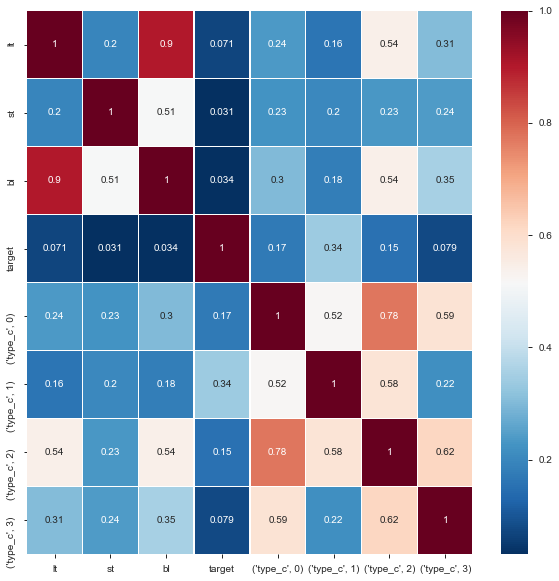

In [28]:
# посмотрим на зависимость фичей друг от друга
pearsoncorr = df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [29]:
# разбиваем на трейн тест
data = df.drop('target', axis=1)
target = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [30]:
# оставляем id компаний
X_train_id = X_train['inn']
X_test_id = X_test['inn']

In [31]:
X_train.drop(columns=['inn'], inplace=True)
X_test.drop(columns=['inn'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
# подготавливаем даные
preparation_pipeline = Pipeline([
        ('imputer', SimpleImputer(fill_value=0)),
        ('std_scaler', StandardScaler())])

In [33]:
X_train = preparation_pipeline.fit_transform(X_train)
X_test = preparation_pipeline.transform(X_test)

In [34]:
# обучаем модель через automl
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = TPOTClassifier(generations=5,
                       population_size=50,
                       cv=cv, scoring='accuracy',
                       verbosity=2, random_state=1)
# perform the search

In [35]:
model.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9734058183955334

Generation 2 - Current best internal CV score: 0.9734058183955334

Generation 3 - Current best internal CV score: 0.9734058183955334

Generation 4 - Current best internal CV score: 0.9734058183955334

Generation 5 - Current best internal CV score: 0.9734058183955334

Best pipeline: DecisionTreeClassifier(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.3, min_samples_leaf=1, min_samples_split=5, n_estimators=100), criterion=gini, max_depth=4, min_samples_leaf=13, min_samples_split=12)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
               generations=5, population_size=50, random_state=1,
               scoring='accuracy', verbosity=2)

In [36]:
pred = model.predict(X_test)

In [37]:
# смотрим результат на тесте

In [38]:
result = {
        'accuracy_score': accuracy_score(y_test, pred),
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'roc_auc_score': roc_auc_score(y_test, pred)}

In [39]:
result

{'accuracy_score': 0.9855072463768116,
 'recall_score': 0.9924812030075187,
 'precision_score': 0.9850746268656716,
 'f1_score': 0.9887640449438201,
 'roc_auc_score': 0.9827270879902459}

In [42]:
model.export('model.pkl')